In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import display
from collections import Counter

In [2]:
# start from 1st week utils.py file

import matplotlib.pyplot as plt
import IPython
from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display
import networkx as nx
import StringIO
from networkx.drawing.nx_pydot import read_dot
from networkx.drawing.nx_pydot import from_pydot
from networkx.drawing.nx_agraph import to_agraph
import pydot

def toGraph(g):
    G = nx.Graph()
    for n in g:
        for n2 in g[n]:
            G.add_edge(n,n2)
    return G

def fromDot(s):
  P_list = pydot.graph_from_dot_data(s)
  return from_pydot(P_list[0])

def draw(G, mapping=None, emapping=None):
    '''draw graph with node mapping and emapping''' 
    A=to_agraph(G)
    A.graph_attr['overlap']='False'
    if mapping:
        if isinstance(mapping, dict):
            mapping = nM(mapping)
        for n in A.nodes():
            mapping(n, A.get_node(n))
    if emapping:
        if isinstance(emapping, dict):
            emapping = eM(emapping)
        for e in A.edges():
            emapping(e, A.get_edge(e[0],e[1]))
    A.layout()
    output = StringIO.StringIO()
    A.draw(output, format='svg')
    return SVG(data=output.getvalue())

# end from 1st week utils.py file

In [3]:
# spider trap avoidance factor
beta = 0.85
# all n connect bidirectional to each other n, and bidirectional to each p
number_n = 3
# all p connect bidirectional to each n, and directional from p to t
number_p = 1
# all f connect bidirectional to each t
number_f = 1

# DO NOT CHANGE BELOW
number_t = 1

In [4]:
# matrix rows and cols order: all n, then all p, then t, then all f
# example rows: n1 n2 n3 p1 p2 t f1 f2
# returns numpy matrix
def setup_matrix():
	# number of outgoing connections
	out_connections_n = number_n + number_p - 1
	out_connections_p = number_n + number_p
	out_connections_t = number_f
	out_connections_f = number_t

	# first node of type at index
	first_n = 0
	first_p = first_n + number_n
	first_t = first_p + number_p
	first_f = first_t + number_t
	total_size = first_f + number_f

	# ranges
	range_n = range(first_p)
	range_p = range(first_p, first_t)
	range_t = range(first_t, first_f)
	range_f = range(first_f, total_size)

	# probability of randomly taking each outgoing connection
	p_n = float(1)/out_connections_n
	p_p = float(1)/out_connections_p
	p_t = float(1)/out_connections_t
	p_f = float(1)/out_connections_f

	# make a numpy matrix of total_size by total_size
	# matrix = np.matrix(np.arange(total_size**2).reshape((total_size, total_size)))
	matrix = np.zeros((total_size, total_size))
	matrix = np.matrix(matrix)

	for x in range(total_size):
		if x in range_n:
			# all n go to all n
			for y in range_n:
				if x != y:
					matrix.put((y*total_size + x), p_n)
			# all n go to all p
			for y in range_p:
				matrix.put((y*total_size + x), p_n)

		elif x in range_p:
			# all p go to all p
			for y in range_p:
				if x != y:
					matrix.put((y*total_size + x), p_p)
			# all p go to all n
			for y in range_n:
				matrix.put((y*total_size + x), p_p)

		elif x in range_t:
			# all t go to f
			for y in range_f:
				matrix.put((y*total_size + x), p_t)

		elif x in range_f:
			# all f to to all t
			for y in range_t:
				matrix.put((y*total_size + x), p_f)

	return matrix

# generates a matrix from a graph
# matrix can be a float matrix for PageRank, or a 0,1 matrix for HITS when hits=true
def setup_matrix_with_graph(graph, hits=False):
	axis_len = len(graph.nodes())
	matrix = np.zeros((axis_len, axis_len))
	matrix = np.matrix(matrix)

	nodes_dict = {}
	number = 0
	# first assign each node a number 
	for node in graph.nodes():
		nodes_dict[node] = number
		number += 1
	# then setup matrix with those numbers as x or y
	for x_node in graph.nodes():
		x_number = nodes_dict[x_node]
		number_neighbours = len(graph[x_node])
		if number_neighbours == 0:
			if not hits:
				# make circular to avoid spider traps
				matrix.put((x_number*axis_len + x_number), 1)
		else:
			out_probability = float(1)/number_neighbours
			for y_node in graph[x_node]:
				y_number = nodes_dict[y_node]
				if hits:
					matrix.put((y_number*axis_len + x_number), 1)
				else:
					matrix.put((y_number*axis_len + x_number), out_probability)

	return matrix

In [5]:
def converge(matrix, beta, vertex=None):
	matrix_size = len(matrix)
	empty_vertex = np.arange(matrix_size, dtype=float)
	scalar_beta = np.full_like(empty_vertex, beta)
	scalar_rest = np.full_like(empty_vertex, 1-beta)
	try:
		vertex.any()
	except:
		vertex = np.full_like(empty_vertex, float(1)/matrix_size)

	first = np.dot(matrix, vertex)
	first = np.multiply(scalar_beta, first)
	second = np.multiply(scalar_rest, vertex)

	result = np.add(first, second)

	return result

In [7]:
def run_test():
	test_matrix = np.matrix([[0, float(1)/2, 0, 0], 
						[float(1)/3, 0, 0, float(1)/2], 
						[float(1)/3, 0, 1, float(1)/2], 
						[float(1)/3, float(1)/2, 0, 0]])
	result = converge(test_matrix, beta).getA1()
	old_result = None
	print("first calculation: ", result)
	while not np.array_equal(result, old_result):
		old_result = result
		result = converge(test_matrix, beta, old_result).getA1()

	return result

def run_program():
	matrix = setup_matrix()
	result = converge(matrix, beta).getA1()
	old_result = None
	while not np.array_equal(result, old_result):
		old_result = result
		result = converge(matrix, beta, old_result).getA1()
    
		return result
        
def run_program_with_matrix(matrix):
	result = converge(matrix, beta).getA1()
	old_result = None
	while not np.array_equal(result, old_result):
		old_result = result
		result = converge(matrix, beta, old_result).getA1()
        
		return result
        

In [8]:
print("converged result: ", run_test())

('first calculation: ', array([0.14375   , 0.21458333, 0.42708333, 0.21458333]))
('converged result: ', array([1.e-323, 2.e-323, 1.e+000, 2.e-323]))


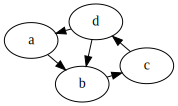

[[0.  0.  0.  0.5]
 [0.  0.  1.  0. ]
 [1.  0.  0.  0.5]
 [0.  1.  0.  0. ]]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 1.]
 [0. 1. 0. 0.]]
[0.25     0.430625 0.494375 0.25    ]


In [9]:
F33 = fromDot('''digraph A {
    a -> b;
    b -> c;
    c -> d;
    d -> a;
    d -> b;
}   
''')

display(draw(F33))

print(setup_matrix_with_graph(F33))
matrix = setup_matrix_with_graph(F33, True)
print(matrix)
print(run_program_with_matrix(matrix))